# Task 2
## Introduction
### What to do
- Prepare 4 random 4-qubit quantum states of your choice.
- Create and train a variational circuit that transforms input states into predefined output states. Namely:
    - if random state 1 is provided, it returns state |0011>
    - if random state 2 is provided, it returns state |0101>
    - if random state 3 is provided, it returns state |1010>
    - if random state 4 is provided, it returns state |1100>

What would happen if you provided a different state? Analyze and discuss the results. For the variational circuit, you can try any circuit you want. You can start from one with a layer of RX, RY and CNOTs, repeated a couple of times (though there are certainly better circuits to achieve this goal). 

### Goals
- Coding skills – clear, readable, well-structured code    
- Communication – well-described results, easy to understand, tidy.
- Reliability – submitted on time, all the points from the task description are met
- Research skills – asking good questions and answering them methodically

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table

C:\Users\Melissa\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


## My solution

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit import execute
import random
qs = Aer.get_backend('qasm_simulator')

### State preparation

First, I'll create four 4-qubit random states. Each of these random states will be used as an input for my circuit, and the outputs will be one of the given output states.

In [3]:
np.random.seed(0)

# These were the states given at the introduction
output_states = ['0011','0101','1010','1100']

# Here, I'll store the input states
random_states = []
for i in range(len(output_states)):
    state = np.random.randint(2, size=4)
    random_states.append(state)

print(random_states)

[array([0, 1, 1, 0]), array([1, 1, 1, 1]), array([1, 1, 1, 0]), array([0, 1, 0, 0])]


The randomly generated states will be mapped to one of the expected output states:

$$
\ket{0110} \rightarrow \ket{0011} \\
\ket{1111} \rightarrow \ket{0101} \\
\ket{1110} \rightarrow \ket{1010} \\
\ket{0100} \rightarrow \ket{1100}
$$

### The circuit
In order to obtain the desired output states, I will be creating a variational circuit based on the hybrid quantum-classical framework DDQCL (Data-Driven Quantum Circuit Learning) designed by Benedetti et al. in '*A generative modeling approach for benchmarking and training shallow quantum circuits*', which can be accessed here: <https://www.nature.com/articles/s41534-019-0157-8>.

Originally, this framework takes an input dataset $\mathcal{D} = \left( \vec{x_1}, \dots, \vec{x_D} \right)$ of randomly generated binary vectors, in my case the random states I generated above. Using this dataset, its goal is to obtain a good approximation to the target probability distribution $P_\mathcal{D}$, in my case I aim for the best possible probabilities for each of the output states.

To do so, I will be using Qiskit to create layers where I'll be applying parameterized rotation gates $R_X(\theta)$ and $R_Z(\theta)$ to each circuit, and then entangling every qubit with each other using parameterized $R_{XX}(\theta)$ gates. This is based on the DDQCL paper, having parameterized single-qubit rotations $ \{ \theta_i^{(l,k)} \} $ and two-qubit entangling rotations $ \{\theta_{ij}^{(l)}\} $ in each layer, where the subscripts denote qubits involved in the operation, $l$ denotes the layer number, and $k\in\{1,2,3\}$ denotes the rotation identifier.

In [4]:
# Setting up some global variables
layers = 4
qubits = 4
measurements = 8000

#### Parameterizable $\theta$ vector
First, I will create a parameterizable $\theta$ vector for each layer, in order to assign unique parameters to each gate during the circuit's creation.

In [5]:
def theta_vectors_generator(layers, qubits):
    vectors = []
    for layer in range(layers):
        vector = ParameterVector('θ_{}'.format(str(layer)), qubits)
        vectors.append(vector)
    return vectors
theta_vectors = theta_vectors_generator(layers, qubits)

#### DDQCL circuit
Now, I'm creating the quantum circuit based on the DDQCL design.

In [6]:
def ddqcl(layers, qubits):
    qr = QuantumRegister(qubits)
    cr = ClassicalRegister(qubits)
    qc = QuantumCircuit(qr, cr)
    for layer in range(layers):
        for qubit in range(qubits):
            qc.rx(theta_vectors[layer].params[qubit], qubit)
            qc.rz(theta_vectors[layer].params[qubit], qubit)
            for other_qubit in range(qubit+1, qubits):
                qc.rxx(theta_vectors[layer].params[qubit], qubit, other_qubit)
        qc.barrier()
    return qc

### Creating initial parameters
The function below creates random parameter values between $\pi$ and $-\pi$.

In [7]:
def theta_values_generator(layers, qubits):
    parameters = []
    for layer in range(layers):
        for qubit in range(qubits):
            for i in -(qubit)*np.random.uniform(-np.pi,np.pi,[1]):
                if i < 3.14 and i > -3.14:
                    parameters.append(i)
                elif i > 0:
                    parameters.append(3.14)
                else:
                    parameters.append(-3.14)
    return parameters

### Cost function

Based on the cost function proposed by Benedetti et al., which is:

$$
\mathcal{C}(\theta)=-\frac{1}{\text{D}}\sum_{d=1}^D \ln{(\max{(\varepsilon, P_{\theta}(\vec{x_d}))})}
$$

where $D$ is the total number of qubits, $d$ is the current qubit, $\varepsilon$ is a very small value in order to avoid having zeroes inside the logarithm, and $P_{\theta}$ are the output probabilities for a given vector. I will be implementing the following cost function, which closely resembles the equation above but is not the same:

In [8]:
def cost_function(qubits, epsilon, random_states, parameters):
    sum_of_ln = 0
    for i in range(qubits):
        counted_state = get_counts_for_state(random_states[i], parameters)
        sum_of_ln += np.log(np.maximum(epsilon, counted_state.get(str(output_states[i]), epsilon)/measurements))
    result = (-1/qubits)*sum_of_ln
    return result

### Other functions

In order to streamline the parameter optimizing phase, where the cost function will be calculated several times based on the inputs given to the circuit, I will leverage the following functions.

- The first function creates a DDQCL circuit with a specific input state before the rotation layers.
- The second function takes the circuit made in the first function and assigns parameter values to it, measuring and returning the output states.

In [9]:
def initialized_ddqcl(state_vector, layers, qubits):
    qr = QuantumRegister(qubits)
    cr = ClassicalRegister(qubits)
    qc = QuantumCircuit(qr, cr)
    for i in range(len(state_vector)):
        if state_vector[i] == 1:
            qc.x(i)
    for layer in range(layers):
        for i in range(qubits):
            qc.rx(theta_vectors[layer].params[i], i)
            qc.rz(theta_vectors[layer].params[i], i)
            for j in range(i+1, qubits):
                qc.rxx(theta_vectors[layer].params[i], i, j)
        qc.barrier()
    return qc

def get_counts_for_state(state, parameters):
    ddqcl = initialized_ddqcl(state, layers, qubits)
    ddqcl = ddqcl.bind_parameters(parameters)
    ddqcl.measure(0,0)
    ddqcl.measure(1,1)
    ddqcl.measure(2,2)
    ddqcl.measure(3,3)
    ddqcl.draw('mpl')
    ddqcl_job = execute(ddqcl, qs, shots = measurements, seed = 1000)
    ddqcl_result = ddqcl_job.result()
    ddqcl_counts = ddqcl_result.get_counts()
    return ddqcl_counts

### Parameter optimization
I created an optimizer where the delta variable changes the circuit paremeters over time, morphing according to the number of iterations without finding a successful set of parameters that lowers the cost. There's further explanation in the comments inside the code below.

Cost: 2.4618077401368312 at iteration 0 with parameters:
[0.0879770538284615, 1.0604337178969194, -3.1872418914081133, -0.6830640413076331, 0.18452535032772455, -2.3521765020970586, 3.5200345501397035, 3.3081874498323307, 0.2199196399743535, -1.751876139715574, -2.914488443502475, -2.999146964849738, -0.33432797065062386, -1.8259051785845428, 0.646732515092012, -2.869066527269568]
Cost: 2.072460412064103 at iteration 11 with parameters:
[-0.04765744358245705, 1.01930486745973, -3.405395608237189, -0.7654325204403332, 0.2870815728602627, -2.125754764892403, 3.4862112075847165, 2.976263102975575, 0.29605522522889666, -1.860223312688613, -2.801777946475192, -3.1222838007499876, -0.6211783300417966, -1.9402261919952624, 0.6892293633893336, -3.0423948115813224]
Cost: 1.8746007832841927 at iteration 25 with parameters:
[0.0008499959066454177, 1.300783524450612, -3.295843551007169, -0.841287227203789, 0.010360282348483796, -2.0625860385521535, 3.2361616592341047, 3.2464765893181466, 0.2708246

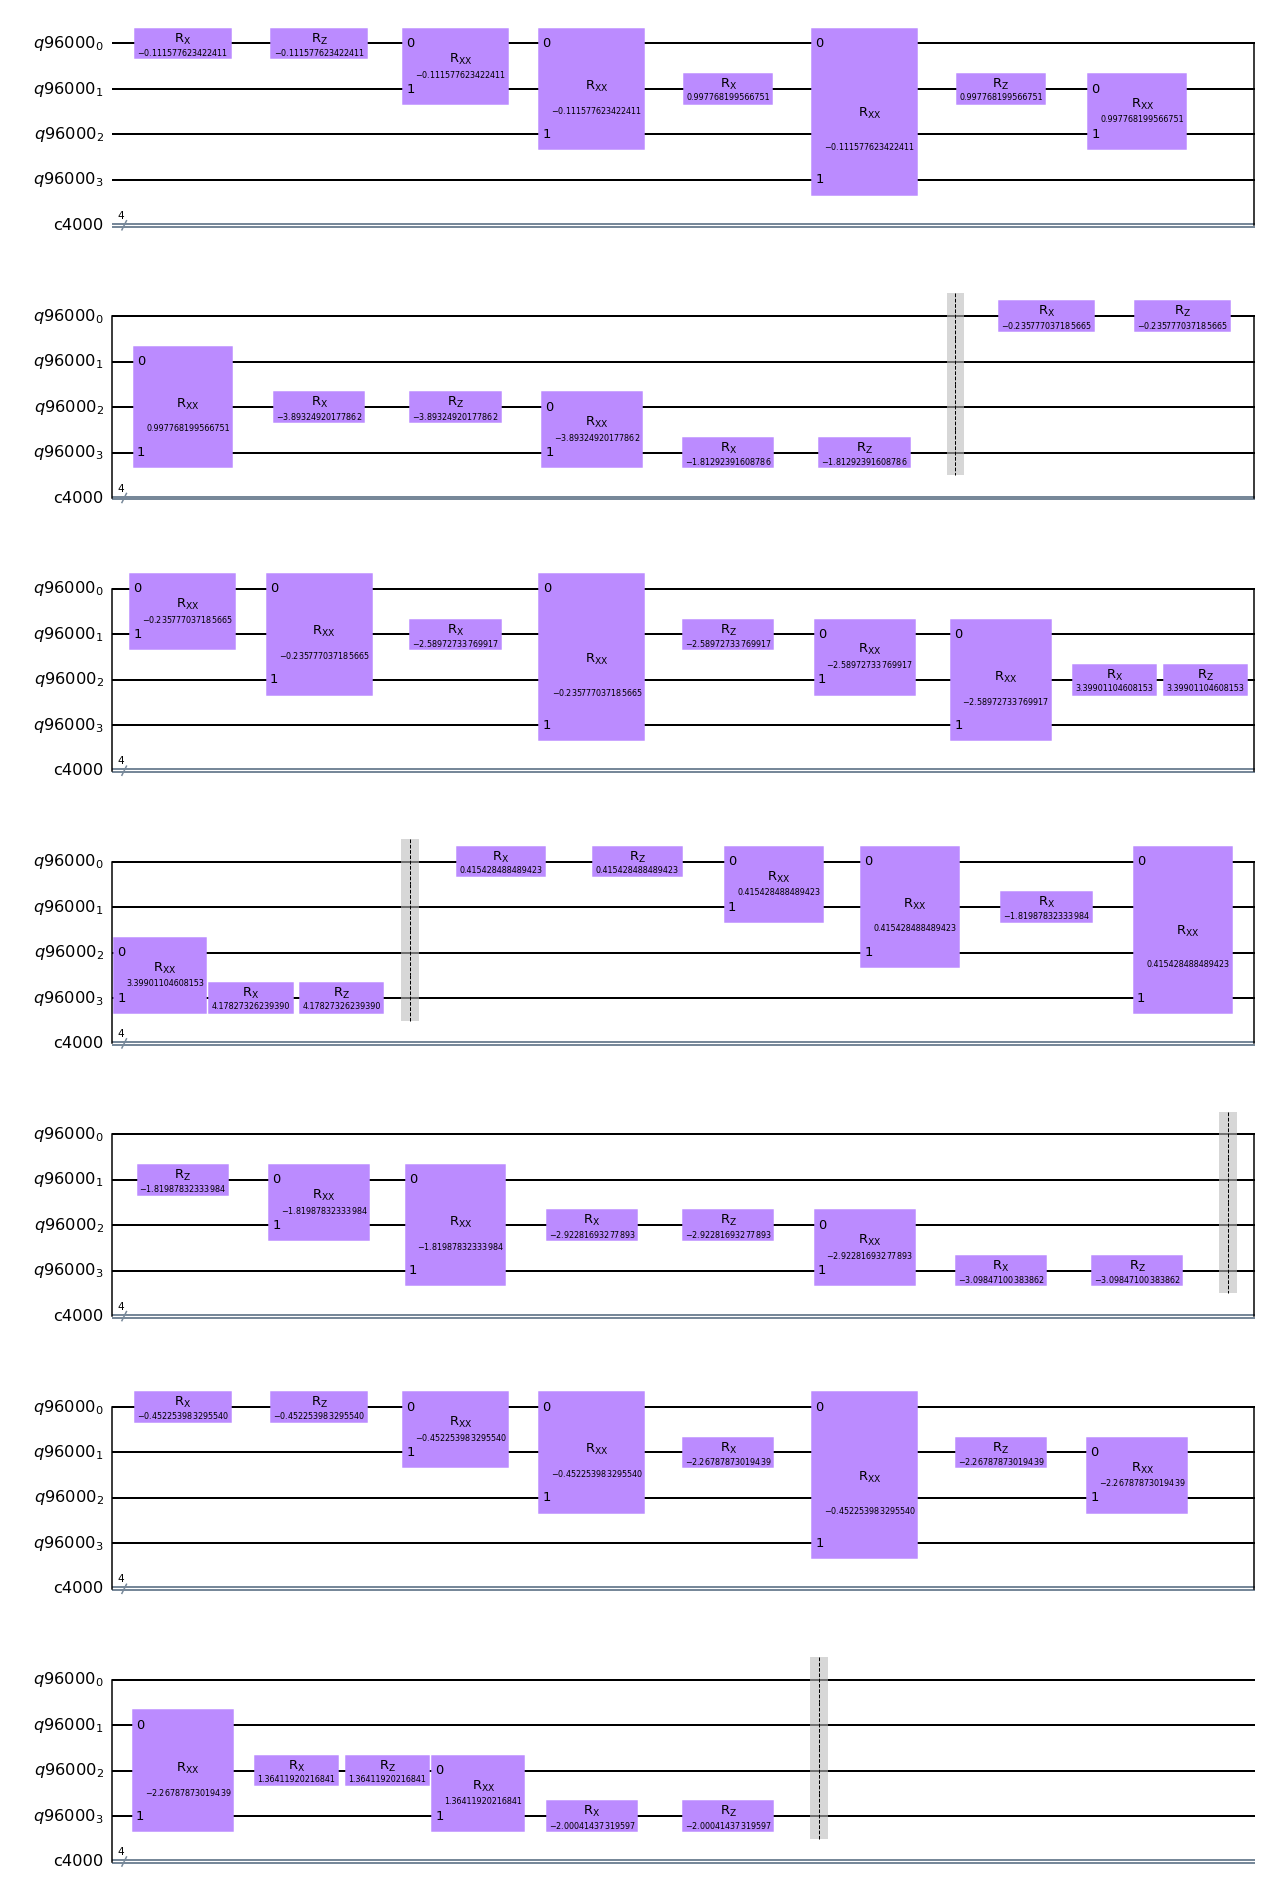

In [10]:
def my_optimizer(current_parameters, delta, iterations, epsilon, best_cost):
    cost_history = [] # Array to store all successful cost reductions
    generated_parameters = []
    original_delta = delta # Variable to freely modify the delta value and be able to come back to its original value later
    generated_parameters.append(current_parameters) # Array to store all the successful parameters
    better = 2 # Variable that I'll use to switch between different deltas if change was successful or not

    for i in range(iterations):
        cummulative_iterations = 0 # Variable to count how many iterations have passed without improving the cost
        new_generated_parameters = []

        # Here, I'm applying different deltas to the last successful generated parameters based on the previous run's success
        for j in range(qubits*layers):
            if better == 1: # successful previous parameters
                new_generated_parameters.append(generated_parameters[-1][j] + delta)
            elif better == 0: # unsuccessful previous parameters
                new_generated_parameters.append(generated_parameters[-1][j] - delta)
            else: # 
                new_generated_parameters.append(generated_parameters[-1][j] + random.uniform(-delta, delta))

        new_cost = cost_function(qubits, epsilon, random_states, new_generated_parameters)

        # Successful cost reductions are stored and variables updated, otherwise deltas are modified
        if new_cost < best_cost:
            cost_history.append(new_cost)
            generated_parameters.append(new_generated_parameters)
            print("Cost: " + str(new_cost) + " at iteration " + str(i) + " with parameters:")
            print(new_generated_parameters)
            best_cost = new_cost
            better = 1
            cummulative_iterations = 0
            delta = original_delta
        elif better == 1:
            cummulative_iterations = cummulative_iterations + 1
            better = 0
        else:
            better = 2
            cummulative_iterations = cummulative_iterations + 1
            # Depending on how many iterations have passed without reaching better parameters,
            # the delta value will be multiplied by the values below. If too many iterations pass
            # without reaching better parameters, the optimizer returns the best circuit it found.
            if cummulative_iterations == 20:
                delta = delta * 1.5
            if cummulative_iterations == 40:
                delta = delta * 1.5
            if cummulative_iterations == 60:
                delta = delta * 0.2
            if cummulative_iterations == 80:
                delta = original_delta
            if cummulative_iterations == 100:
                parameterized_best_circuit = ddqcl(layers, qubits).bind_parameters(generated_parameters[-1])
                return parameterized_best_circuit, generated_parameters[-1], cost_history
    parameterized_best_circuit = ddqcl(layers, qubits).bind_parameters(generated_parameters[-1])
    return parameterized_best_circuit, generated_parameters[-1], cost_history


last_circuit, best_parameters, cost_history = my_optimizer(theta_values_generator(layers,qubits), np.pi/8, 1000, 0.0001, 10)
last_circuit.draw('mpl')

#### Benchmarking
Although the optimizer I created is nothing special, here I'm displaying how much the cost decreased everytime it found better parameters. This optimizer can be improved further, since its rules were set by me by trial and error.

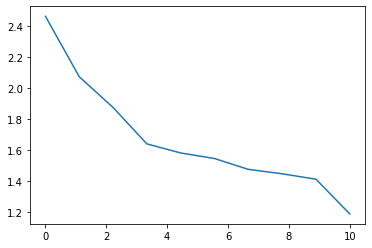

In [11]:
plt.plot(np.linspace(0,len(cost_history),len(cost_history)), cost_history)
plt.show()


### Measurements

Output values for input state [0 1 1 0] which should give 0011:


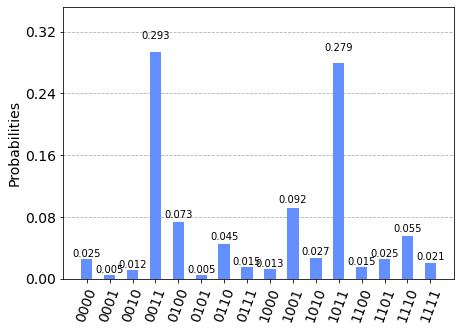

In [20]:
counts_0 = get_counts_for_state(random_states[0], best_parameters)
print("Output values for input state " + str(random_states[0]) +" which should give " + output_states[0] + ":")
plot_histogram(counts_0)

Output values for input state [1 1 1 1] which should give 0101:


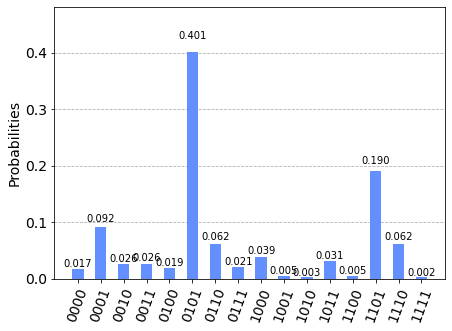

In [13]:
counts_1 = get_counts_for_state(random_states[1], best_parameters)
print("Output values for input state " + str(random_states[1]) +" which should give " + output_states[1] + ":")
plot_histogram(counts_1)

Output values for input state [1 1 1 0] which should give 1010:


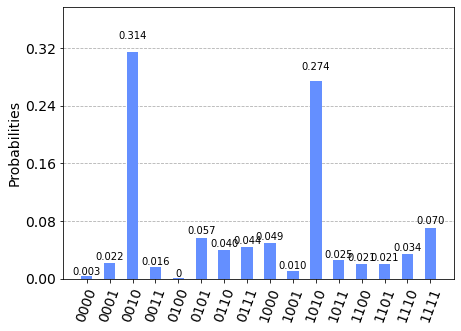

In [14]:
counts_2 = get_counts_for_state(random_states[2], best_parameters)
print("Output values for input state " + str(random_states[2]) +" which should give " + output_states[2] + ":")
plot_histogram(counts_2)

Output values for input state [0 1 0 0] which should give 1100:


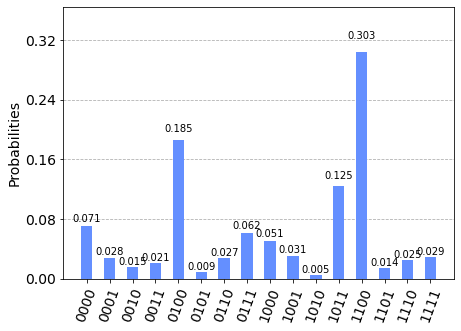

In [15]:
counts_3 = get_counts_for_state(random_states[3], best_parameters)
print("Output values for input state " + str(random_states[3]) +" which should give " + output_states[3] + ":")
plot_histogram(counts_3)

In [16]:
print(best_parameters)

[-0.11157762342241051, 0.9977681995667513, -3.893249201778619, -1.8129239160878554, -0.23577703718566478, -2.5897273376991747, 3.3990110460815264, 4.178273262393897, 0.41542848848942326, -1.8198783233398448, -2.922816932778931, -3.098471003838617, -0.4522539832955403, -2.2678787301943926, 1.3641192021684116, -2.00041437319597]


## Discussion

### Results
Although not always perfect, all the different runs of the optimizer that I did gave a minimum of **three correct answers**, such as the ones seen above. In some runs, there's an additional output state with similar probability to the state we're looking for.

Something I didn't explore much into were the hyperparameters such as $\varepsilon$ for the cost function, or the number of layers the circuit should have. What I have right now is close to the perfect answer (that is, the four states correctly mapped without other high probability states that could cause confusion), but I'm sure that tuning the hyperparameters could eventually lead to a better circuit and better outputs.

### Optimizer
There's a lot of room for improvement, with the right rules it could take considerably less iterations to sustantially lower the cost.

One thing I believe could be beneficial is: when a successful parameter set that lowers the cost is found, try adding randomized values to each element with the same sign as the previous addition ( $+$ or $-$ ), seeing if going further that way in different proportions is useful or not; if that doesn't work, try adding the same numbers with switched signs ( $-$ or $+$ ).

### Cost function
One final thing I believe could be interesting to try is to measure the cost differently. Something I noticed when measuring the outputs of the initialized circuits is that errors end up being in either 0011 and 1100, or 1010 and 0101. This leds me to believe that these states are treated a specific way at least in the qasm_simulator.

One idea I have is transpiling the code into basic gates for a quantum computer with a known topology and study how the qubits interact, seeing the relations between the different connections they have to each other. This way, I think I could weight each mapped qubit's cost function result and sum those values as a circuit cost function, so to say, to consider some results better than others.

Another idea I have is to read the states that I don't want and make a decision based on that. Let's say that I'm getting high probabilities on 1010 and 1110, and I'm only expecting to see 1010: what if I make results with a high probability of 1110 more costly than others to avoid getting that state in my final circuit?

## Thanks
Just wanted to say thanks to the Quantum Open Source Foundation for preparing these tasks. Due to very limited time, I wasn't able to try the other tasks during the 2-week periodm but I chose this one, learned a lot and I'm happy with the results. I will definitely be improving this notebook in the future, but I will leave the main branch at GitHub as the untouched submission within the time period until the chosen candidates are announced.